In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from DecisionTree import DecisionTree
from sklearn.metrics import accuracy_score,confusion_matrix, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from BaggingClassifier import BaggingClassifier
%run DecisionTree.py
%run BaggingClassifier.py
%run AdaBoost.py


In [2]:
# Load dataset
data = pd.read_csv('heart.csv')
# Binary encoding for 'Sex' and 'ExerciseAngina'
data['Sex'] = data['Sex'].map({'M': 1, 'F': 0})
data['ExerciseAngina'] = data['ExerciseAngina'].map({'Y': 1, 'N': 0})
# Extract features and labels
X = data.drop(columns=['HeartDisease'])
y = data['HeartDisease']

# One-Hot Encoding for non-binary categorical features
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)

if categorical_cols:  # Only encode if there are categorical features
    encoded_array = encoder.fit_transform(X[categorical_cols])
    encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols))
    X = pd.concat([X.drop(columns=categorical_cols), encoded_df], axis=1)

X = X.to_numpy()
y = y.to_numpy()

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

#X_val (10%) → Used for hyperparameter tuning.
# X_test (20%) → Used for final evaluation.
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, random_state=42, stratify=y_temp
)

# Decision Tree Classifier

Tuning the hyperparameters of a Decision Tree Classifier using validation set.

In [3]:
# tune the hyperparameters of the DecisionTree model
max_depths = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
min_samples_splits = [2, 4, 6, 8, 10, 20, 40, 60, 80, 100]

# Initialize best hyperparameters
best_max_depth = None
best_min_samples_split = None
best_accuracy_dt = 0

# Tune hyperparameters
for max_depth in max_depths:
    for min_samples_split in min_samples_splits:
        model_dt = DecisionTree(max_depth=max_depth, min_sample_split=min_samples_split)
        model_dt.fit(X_train, y_train)
        y_pred_dt = model_dt.predict(X_val)
        accuracy_dt = accuracy_score(y_val, y_pred_dt)
        if accuracy_dt > best_accuracy_dt:
            best_max_depth = max_depth
            best_min_samples_split = min_samples_split
            best_accuracy_dt = accuracy_dt

print(f'Best max_depth: {best_max_depth}')
print(f'Best min_samples_split: {best_min_samples_split}')
print(f'Best accuracy: {best_accuracy_dt}')
            

Best max_depth: 5
Best min_samples_split: 20
Best accuracy: 0.8695652173913043


Training a Decision Tree Classifier on the test set using best hyperparameters.

In [4]:
# Train the DecisionTree model with the best hyperparameters
dt_model = DecisionTree(max_depth=best_max_depth, min_sample_split=best_min_samples_split)
dt_model.fit(X_train, y_train)

# get predictions and accuracy of the DecisionTree model on the test set
y_pred_dt_test = dt_model.predict(X_test)
test_accuracy_dt = accuracy_score(y_test, y_pred_dt_test)
print(f"Accuracy of DecisionTree: {test_accuracy_dt}")

Accuracy of DecisionTree: 0.842391304347826


Evaluating the performance of the Decision Tree Classifier on the test set.

F1 Score of DecisionTree: 0.8542713567839196


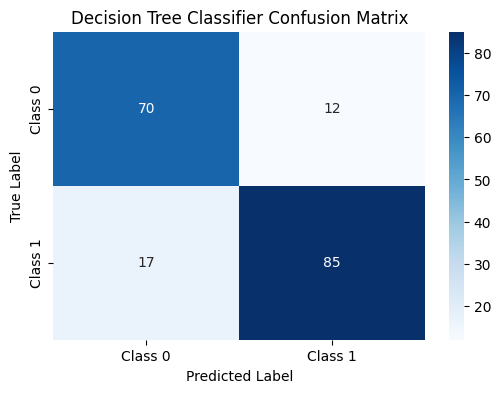

In [5]:
# calculate the F1 score of the DecisionTree model
f1_dt = f1_score(y_test, y_pred_dt_test)
print(f"F1 Score of DecisionTree: {f1_dt}")
# Plot Confusion Matrix for DecisionTree
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt_test)
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

plot_confusion_matrix(conf_matrix_dt, "Decision Tree Classifier Confusion Matrix")

# Bagging Ensemble

Tuning the hyperparameters of a Bagging Ensemble Classifier using validation set

In [6]:
# tune the hyperparameters of the Boosting
n_estimators = [20, 25, 30, 35, 40, 45, 50]

# Initialize best hyperparameters
best_n_estim = None
best_accuracy_bag = 0

# Tune hyperparameters
for n_estm in n_estimators:
    model_bag = BaggingClassifier(base_learner=DecisionTree, n_estimators=n_estm)
    model_bag.fit(X_train, y_train)
    y_pred_bag = model_bag.predict(X_val)
    accuracy_bag = accuracy_score(y_val, y_pred_bag)
    if accuracy_bag > best_accuracy_bag:
        best_n_estim = n_estm
        best_accuracy_bag = accuracy_bag

print(f'Best n_estimators: {best_n_estim}')
print(f'Best accuracy: {best_accuracy_bag}')

Best n_estimators: 20
Best accuracy: 0.8478260869565217


Training the Ensemble Classifier on the test set using best hyperparameters.

In [7]:
#Train the Bagging model with the best hyperparameters
bag_model = BaggingClassifier(base_learner=DecisionTree, n_estimators=best_n_estim)
bag_model.fit(X_train, y_train)

# get predictions and accuracy of the Bagging model on the test set
y_pred_bag_test = bag_model.predict(X_test)
test_accuracy_bag = accuracy_score(y_test, y_pred_bag_test)
print(f"Accuracy of Bagging: {test_accuracy_bag}")


Accuracy of Bagging: 0.8152173913043478


Evaluating the performance of the Ensemble Classifier on the test set.

F1 Score of Bagging: 0.83


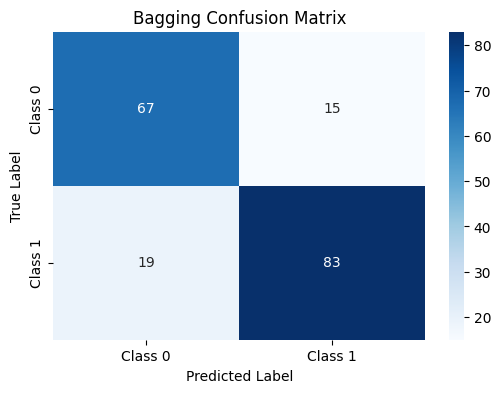

In [8]:
# calculate the F-1 score
f1_bag = f1_score(y_test, y_pred_bag_test)
print(f"F1 Score of Bagging: {f1_bag}")

#plot the confusion matrix
conf_matrix_bag = confusion_matrix(y_test, y_pred_bag_test)

def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

plot_confusion_matrix(conf_matrix_bag, "Bagging Confusion Matrix")


# Adaboost Ensemble

Tuning the hyperparameters of a Adaboost Ensemble Classifier using validation set

In [9]:
# tune the hyperparameters of Adaboost
n_weak_learners = [20, 50, 100]

# Initialize best hyperparameters
best_n_weak_learners = None
best_accuracy_ada = 0

# Tune hyperparameters
for n_weak_learner in n_weak_learners:
    model_ada = AdaBoost(n_weak_learner)
    model_ada.fit(X_train, y_train)
    y_pred_ada = model_ada.predict(X_val)
    accuracy_ada = accuracy_score(y_val, y_pred_ada)
    if accuracy_ada > best_accuracy_ada:
        best_n_weak_learners = n_weak_learner
        best_accuracy_ada = accuracy_ada

print(f'Best n_weak_learners: {best_n_weak_learners}')
print(f'Best accuracy: {best_accuracy_ada}')

Best n_weak_learners: 20
Best accuracy: 0.8478260869565217


Training the Ensemble on the test set using best hyperparameters.

In [10]:
#train the Adaboost model with the best hyperparameters
ada_model = AdaBoost(best_n_weak_learners)
ada_model.fit(X_train, y_train)

# get predictions and accuracy of the Adaboost model on the test set
y_pred_ada_test = ada_model.predict(X_test)
test_accuracy_ada = accuracy_score(y_test, y_pred_ada_test)
print(f"Accuracy of Adaboost: {test_accuracy_ada}")


Accuracy of Adaboost: 0.782608695652174


Evaluating the performance of the Ensemble on the test set.

F1 Score of Adaboost: 0.8


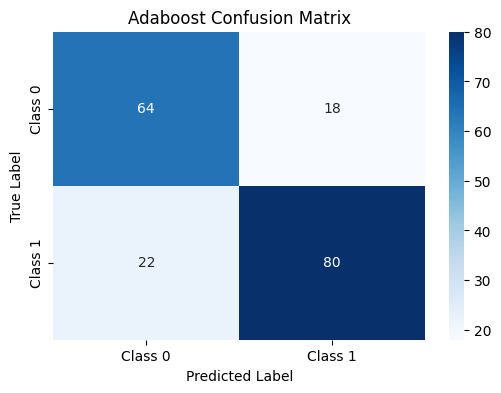

In [11]:
# calculate the F-1 score
f1_ada = f1_score(y_test, y_pred_ada_test)
print(f"F1 Score of Adaboost: {f1_ada}")

#plot the confusion matrix
conf_matrix_ada = confusion_matrix(y_test, y_pred_ada_test)

def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()
plot_confusion_matrix(conf_matrix_ada, "Adaboost Confusion Matrix")